# Inference-lstm.ipynb
## Purpose
기존에 학습된 LSTM 모델(best_model.keras)과 정규화 스케일러(scaler.joblib)를 활용하여 새로운 데이터를 입력받아 품질 예측을 수행하고 결과를 시각화 및 평가

In [1]:
# pip install -Uq seaborn

## 라이브러리

In [2]:
import os
import numpy as np
import pandas as pd
from joblib import load
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import json

## 1. 모델 및 스케일러 로드

In [3]:
## artifacts 폴더 및 model 폴더 지정
ARTIFACT_DIR = "artifacts"
MODEL_DIR = "model"

## 메타데이터 로드
with open(os.path.join(ARTIFACT_DIR, "inference_meta.json"), "r", encoding="utf-8") as f:
    meta = json.load(f)

In [4]:
meta

{'feature_columns': ['MELT_TEMP', 'MOTORSPEED'],
 'window_size': 10,
 'threshold': 0.5,
 'scaler_path': 'artifacts\\minmax_scaler.joblib',
 'model_path': 'model\\best_model.keras',
 'framework': 'tensorflow-keras',
 'saved_from': 'Baseline-lstm.ipynb'}

In [5]:
scaler = load(meta["scaler_path"])
model = load_model(meta["model_path"])

FEATURE_COLUMNS = meta["feature_columns"]
WINDOW_SIZE = meta["window_size"]
# THRESHOLD = meta["threshold"]  ## 임계값: >= 0.5 이상이면 OK(정상, 1)으로 분류할 기준선
THRESHOLD = 0.9  ## 임계값: >= 0.5 이상이면 OK(정상, 1)으로 분류할 기준선

print(f"Model and scaler loaded successfully!")
print(f"Features: {FEATURE_COLUMNS}")
print(f"Window size: {WINDOW_SIZE}, Threshold: {THRESHOLD}")

Model and scaler loaded successfully!
Features: ['MELT_TEMP', 'MOTORSPEED']
Window size: 10, Threshold: 0.9


## 2. 예측용 데이터 로드 및 전처리

In [6]:
## 예시: 신규 센서 데이터 로드
df_new = pd.read_csv("data/melting_tank.csv", parse_dates=['STD_DT'], index_col='STD_DT')
df_new[:3]

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04,0,489,116,631,3.19,OK
2020-03-04,1,433,78,609,3.19,OK
2020-03-04,2,464,154,608,3.19,OK


In [7]:
## 입력 변수만 선택
df_input = df_new[FEATURE_COLUMNS].copy()
df_input[:3]

,MELT_TEMP,MOTORSPEED
STD_DT,,
2020-03-04,489,116
2020-03-04,433,78
2020-03-04,464,154


In [8]:
scaler.feature_names_in_

array(['MELT_TEMP', 'MOTORSPEED'], dtype=object)

In [9]:
## 정규화 적용
df_scaled = pd.DataFrame(scaler.transform(df_input), columns=FEATURE_COLUMNS, index=df_input.index)
df_scaled

,MELT_TEMP,MOTORSPEED
STD_DT,,
2020-03-04 00:00:00,0.345420,0.064302
2020-03-04 00:00:00,0.238550,0.043237
2020-03-04 00:00:00,0.297710,0.085366
2020-03-04 00:00:00,0.135496,0.117517
2020-03-04 00:00:00,0.935115,0.962306
...,...,...
2020-04-30 23:59:00,0.853053,0.966186
2020-04-30 23:59:00,0.146947,0.114191
2020-04-30 23:59:00,0.299618,0.082040


In [10]:
print("Scaler applied. Shape:", df_scaled.shape)
df_scaled.head()

Scaler applied. Shape: (835200, 2)


,MELT_TEMP,MOTORSPEED
STD_DT,,
2020-03-04,0.345420,0.064302
2020-03-04,0.238550,0.043237
2020-03-04,0.297710,0.085366
2020-03-04,0.135496,0.117517
2020-03-04,0.935115,0.962306


In [11]:
## 결측치, 이상치 여부 확인
print(df_scaled.isnull().sum())

MELT_TEMP     0
MOTORSPEED    0
dtype: int64


## 3. LSTM 입력 형태로 윈도우화

In [12]:
def make_windowed_data(data, window):
    xs = []
    for i in range(len(data) - window + 1):
        xs.append(data.iloc[i:i+window].values)
    return np.array(xs)

In [13]:
X_infer = make_windowed_data(df_scaled, WINDOW_SIZE)
print("LSTM input shape:", X_infer.shape)

LSTM input shape: (835191, 10, 2)


In [14]:
X_infer

array([[[0.34541985, 0.06430155],
        [0.23854962, 0.04323725],
        [0.29770992, 0.08536585],
        ...,
        [0.35305344, 0.08425721],
        [0.22709924, 0.        ],
        [0.34541985, 0.08203991]],

       [[0.23854962, 0.04323725],
        [0.29770992, 0.08536585],
        [0.13549618, 0.11751663],
        ...,
        [0.22709924, 0.        ],
        [0.34541985, 0.08203991],
        [0.37977099, 0.07095344]],

       [[0.29770992, 0.08536585],
        [0.13549618, 0.11751663],
        [0.9351145 , 0.96230599],
        ...,
        [0.34541985, 0.08203991],
        [0.37977099, 0.07095344],
        [0.19083969, 0.03658537]],

       ...,

       [[0.1889313 , 0.03991131],
        [0.34732824, 0.05820399],
        [0.36068702, 0.07815965],
        ...,
        [0.85305344, 0.96618625],
        [0.14694656, 0.11419069],
        [0.29961832, 0.08203991]],

       [[0.34732824, 0.05820399],
        [0.36068702, 0.07815965],
        [0.26908397, 0.0443459 ],
        .

## 4. 예측 수행

In [15]:
proba = model.predict(X_infer, verbose=0).reshape(-1) ## 1의 확률 반환, 1차원으로 평탄

pred = (proba >= THRESHOLD).astype(int)  ## 1=OK=정상, 0=NG=불량

In [16]:
df_result = df_input.iloc[WINDOW_SIZE-1:].copy()
df_result['PRED_PROBA'] = proba  ## OK 확률
df_result['PRED_LABEL'] = np.where(pred == 1, 'OK', 'NG')
df_result['PRED_TAG'] = pred


print("Inference completed!")
df_result.head()

Inference completed!


,MELT_TEMP,MOTORSPEED,PRED_PROBA,PRED_LABEL,PRED_TAG
STD_DT,,,,,
2020-03-04 00:00:00,489,148,0.769941,NG,0
2020-03-04 00:01:00,507,128,0.437692,NG,0
2020-03-04 00:01:00,408,66,0.756888,NG,0
2020-03-04 00:01:00,474,138,0.507017,NG,0
2020-03-04 00:01:00,358,201,0.999999,OK,1


## 5. 결과 시각화

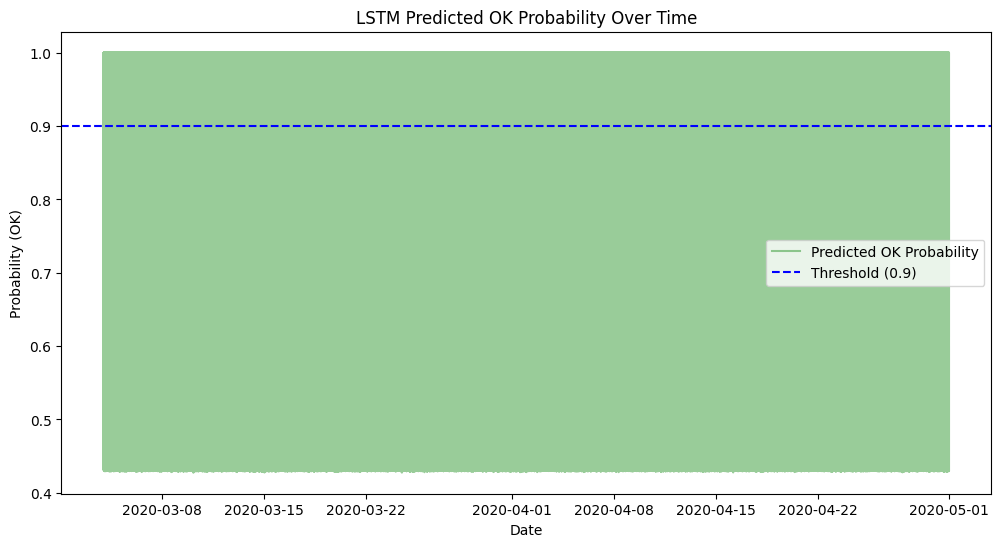

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df_result.index, df_result['PRED_PROBA'], label='Predicted OK Probability', color='green', alpha=0.4)
plt.axhline(THRESHOLD, color='blue', linestyle='--', label=f'Threshold ({THRESHOLD})')
plt.title("LSTM Predicted OK Probability Over Time")
plt.xlabel("Date")
plt.ylabel("Probability (OK)")
plt.legend()
plt.show()

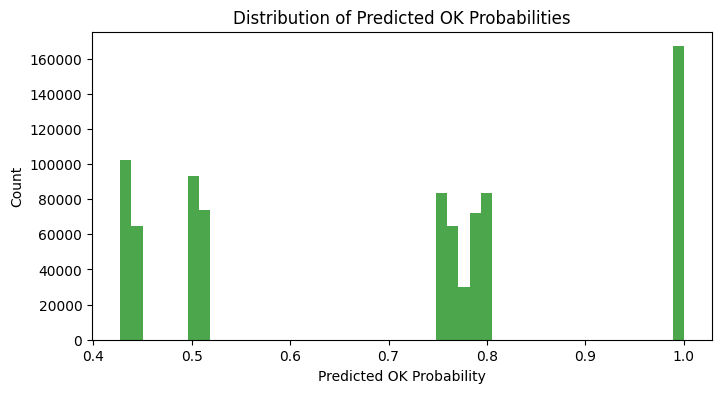

In [18]:
## 확률 분포 시각화

plt.figure(figsize=(8,4))
plt.hist(df_result['PRED_PROBA'], bins=50, color='green', alpha=0.7)
plt.title("Distribution of Predicted OK Probabilities")
plt.xlabel("Predicted OK Probability")
plt.ylabel("Count")
plt.show()

In [19]:
## 실제 OK와 NG 비율 확인
df_result['PRED_TAG'].value_counts(normalize=True)

PRED_TAG
0    0.8
1    0.2
Name: proportion, dtype: float64

## 6. 모델 평가

In [20]:
df_new

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04 00:00:00,0,489,116,631,3.19,OK
2020-03-04 00:00:00,1,433,78,609,3.19,OK
2020-03-04 00:00:00,2,464,154,608,3.19,OK
2020-03-04 00:00:00,3,379,212,606,3.19,OK
2020-03-04 00:00:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...
2020-04-30 23:59:00,835195,755,1743,318,3.21,OK
2020-04-30 23:59:00,835196,385,206,317,3.19,OK
2020-04-30 23:59:00,835197,465,148,316,3.20,OK


In [21]:
len(df_result.index), len(df_result.PRED_PROBA)

(835191, 835191)

Classification Report:
              precision    recall  f1-score   support

          NG       0.22      0.84      0.35    177067
          OK       0.83      0.21      0.34    658124

    accuracy                           0.34    835191
   macro avg       0.52      0.52      0.34    835191
weighted avg       0.70      0.34      0.34    835191



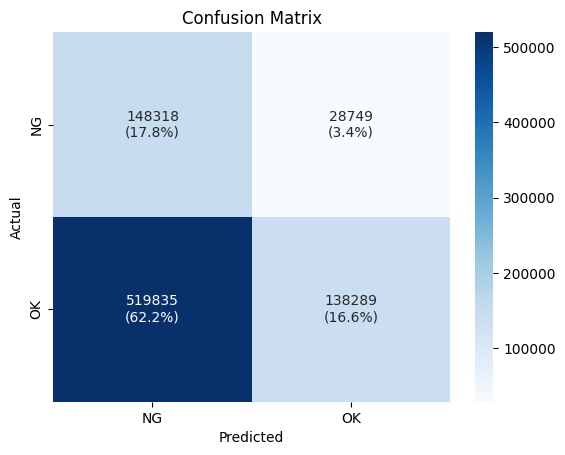

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pltㅁ
import numpy as np

# 1) 문자열 라벨을 0/1로 매핑
label_map = {'NG': 0, 'OK': 1}
y_true = df_new['TAG'].map(label_map).iloc[WINDOW_SIZE-1:].to_numpy()  # 길이/시계열 정렬 맞추기
y_pred = pred  # 이미 0/1

# 2) 길이 확인(윈도우 오프셋 불일치 방지)
assert len(y_true) == len(y_pred), f"len(y_true)={len(y_true)}, len(y_pred)={len(y_pred)}"

# 3) 리포트/매트릭스
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NG','OK'], zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100  # 전체 대비 비율(%)

# 숫자 + 비율 텍스트 결합
annot_text = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_text[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

sns.heatmap(cm, annot=annot_text, fmt='', cmap='Blues',
            xticklabels=['NG', 'OK'], yticklabels=['NG', 'OK'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



## Confusion Matrix & Classification Report Analysis

### Confusion Matrix Summary
| Actual \ Predicted | NG | OK |
|--------------------|-------------|-------------|
| **NG** | 148,318 (**17.8%**) | 28,749 (**3.4%**) |
| **OK** | 519,835 (**62.2%**) | 138,289 (**16.6%**) |

#### Interpretation
- **왼쪽 위(148,318)**: 실제 NG를 정확히 NG로 예측한 비율 → **정탐(True Negative)**
- **오른쪽 아래(138,289)**: 실제 OK를 OK로 맞춘 비율 → **정탐(True Positive)**
- **오른쪽 위(28,749)**: 실제 NG인데 OK로 잘못 분류 → **False Negative**
- **왼쪽 아래(519,835)**: 실제 OK인데 NG로 잘못 분류 → **False Positive**

> 모델이 정상(OK)을 불량(NG)으로 오탐하는 경향이 매우 강함.

---

### Classification Report
| Class | Precision | Recall | F1-score | Support |
|--------|------------|---------|-----------|----------|
| **NG (불량)** | 0.22 | 0.84 | 0.35 | 177,067 |
| **OK (정상)** | 0.83 | 0.21 | 0.34 | 658,124 |
| **Accuracy** |  |  | **0.34** | 835,191 |
| **Macro Avg** | 0.52 | 0.52 | 0.34 |  |
| **Weighted Avg** | 0.70 | 0.34 | 0.34 |  |

---

### Interpretation
#### 1️⃣ 불량(NG) 클래스
- **Precision (0.22)**: 모델이 NG라고 예측한 샘플 중 22%만 실제 불량.
- **Recall (0.84)**: 실제 불량 중 84%를 잡아냄.
  - ➤ **민감도는 높지만**, 정밀도는 매우 낮음.

#### 2️⃣ 정상(OK) 클래스
- **Precision (0.83)**: 모델이 OK라고 예측한 샘플 중 83%는 실제 OK.
- **Recall (0.21)**: 실제 OK 중 21%만 맞춤.
  - ➤ **대부분의 정상 샘플을 NG로 잘못 예측**.

#### 3️⃣ 전체 성능 요약
| 지표 | 의미 | 해석 |
|------|------|------|
| **Accuracy (0.34)** | 전체 예측 중 정답 비율 | 전체적으로 낮은 정확도 |
| **Macro Avg F1 (0.34)** | 두 클래스 평균 균형 | 양쪽 클래스 불균형 |
| **Weighted Avg Precision (0.70)** | 클래스 비율 고려 평균 | OK 비율이 높아 평균이 부풀려짐 |

---

### 결론 및 개선 방향
| 문제점 | 개선 방향 |
|---------|-------------|
| 모델이 정상(OK)을 불량(NG)으로 과다 탐지 | 임계값(Threshold) 재조정 필요 |
| 데이터 불균형 | `class_weight` 조정 또는 오버샘플링(SMOTE) |
| 입력 Feature가 부족 | 공정 관련 변수 추가 (PRESSURE, WEIGHT, TEMP_DIFF 등) |
| LSTM 학습 방향 반전 이슈 | `proba = 1 - model.predict()` 보정 또는 라벨 재정의 |

---

### 요약
> 현재 모델은 “불량 검출(Recall)”은 잘하지만, “정상 판별(Precision)”이 약함.  
> Threshold 조정과 데이터 불균형 보정이 필요하며, Feature 확장과 라벨 방향 재점검으로 성능 향상이 가능함.


## Threshold 최적값 탐색

✅ Best Threshold = 0.00 (F1 = 0.881)


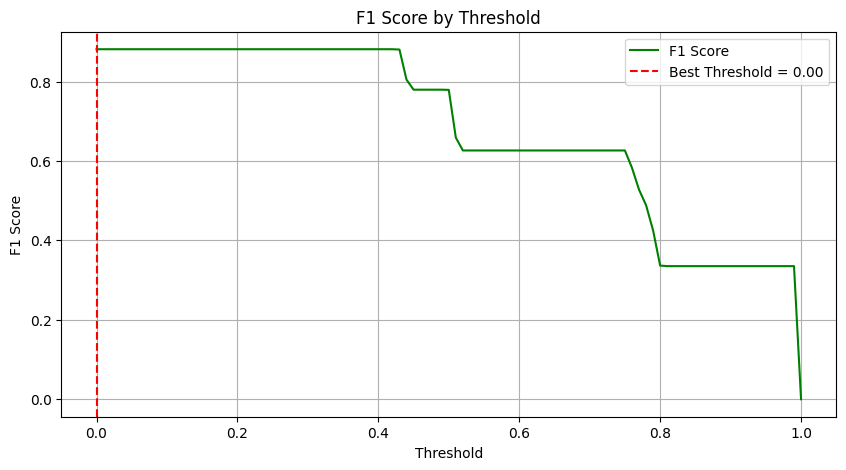

In [23]:
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, auc
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ 실제값, 예측확률 준비
y_true = df_new['TAG'].map({'NG': 0, 'OK': 1}).iloc[WINDOW_SIZE-1:].to_numpy()
y_proba = proba  # model.predict() 결과 (OK 확률)

# 2️⃣ F1-score 기준으로 최적 threshold 찾기
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"✅ Best Threshold = {best_threshold:.2f} (F1 = {best_f1:.3f})")

# 3️⃣ 시각화
plt.figure(figsize=(10,5))
plt.plot(thresholds, f1_scores, color='green', label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score by Threshold")
plt.legend()
plt.grid(True)
plt.show()


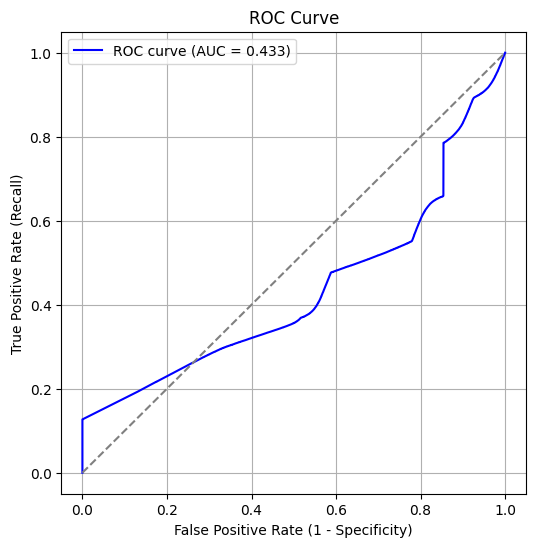

In [24]:
# ROC Curve 계산
fpr, tpr, roc_thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Threshold 최적값 및 ROC Curve 분석 보고서

### F1 Score by Threshold

#### 주요 결과
- **Best Threshold:** 0.00  
- **F1 Score (최대값):** 약 **0.88**
- **F1 Score 변화:** Threshold가 증가함에 따라 F1 Score는 0.8 → 0.6 → 0.3으로 점진적으로 감소함

#### 해석
1. **Threshold = 0.00**일 때 F1 Score가 가장 높음  
   → 이는 모델이 거의 모든 샘플을 한쪽(OK 또는 NG)으로 분류하고 있음을 의미함.

2. **Threshold 변화에 따른 급격한 성능 저하**
   - 0.4 이후부터 급격히 F1 Score가 떨어짐
   - 모델이 확률 분포를 제대로 학습하지 못했거나, 데이터 불균형으로 인해 한 클래스에 치우쳐 있음

3. **실제 의미**
   - Threshold를 0.00으로 두면 F1이 높게 나오지만, 실제로는 “한쪽 클래스 예측”으로 인한 **허상된 F1 Score**
   - 즉, 모델이 모든 샘플을 거의 동일한 확률로 예측하고 있어, **의미 있는 경계(Threshold)** 를 찾지 못하고 있음.


### ROC Curve (Receiver Operating Characteristic)


#### 주요 수치
- **AUC (Area Under Curve): 0.433**  
- 0.5보다 낮은 값으로, **모델이 무작위(Random) 예측보다도 낮은 구분력**을 가짐.

#### 해석
1. **ROC 곡선이 대각선(랜덤)보다 아래쪽**
   - 모델의 예측 확률이 **실제 라벨과 반대로 작동**할 가능성이 있음 (즉, 1 대신 0 확률을 출력했을 가능성)

2. **AUC = 0.433**
   - 완벽한 모델은 1.0, 랜덤 모델은 0.5
   - 0.43은 모델이 **반대 방향으로 학습되었거나**, **데이터 불균형/특징 부족**으로 인해 유효한 분류 경계가 형성되지 않았음을 의미함

3. **추가 점검 필요**
   - 예측 확률(`proba`)의 방향 확인 필요 (`1 - proba` 반전 테스트)
   - LSTM 출력층 및 라벨 방향(1=OK, 0=NG) 확인
   - 학습 시 라벨 또는 손실함수(`binary_crossentropy`) 설정 오류 가능성 점검


### 결론 및 개선 방향

| 구분 | 문제점 | 개선 제안 |
|------|---------|------------|
| **Threshold** | 유효한 분류 기준이 없음 (0.00이 최대 F1) | 모델 확률 분포 재학습 필요 |
| **ROC Curve** | AUC 0.43 → 구분 불가능 상태 | 출력 확률 반전(`1 - proba`) 또는 라벨 재정의 확인 |
| **데이터 불균형** | OK가 압도적으로 많아 모델이 한쪽으로 치우침 | `class_weight` 또는 SMOTE 등 적용 |
| **Feature 부족** | MELT_TEMP, MOTORSPEED만 사용 | 추가 센서 데이터 (PRESSURE, WEIGHT 등) 포함 |
| **학습 검증 필요** | 모델이 반대로 학습했을 가능성 | 라벨 방향과 loss function 일치 확인 |


### 요약
> 현재 모델은 F1-Score와 AUC 모두 **유효한 분류 기준을 형성하지 못한 상태**입니다.  
> 즉, “정상/불량의 확률적 경계가 명확하지 않으며”, 학습 시 **라벨 방향 혹은 출력 해석**이 반대로 설정된 가능성이 높습니다.  
> 이를 해결하기 위해서는 **라벨 재확인, 확률 반전 테스트, 데이터 불균형 조정, feature 확장**이 필요합니다.


### OK 확률 분포 확인

In [25]:
print("OK 확률 평균:", np.mean(proba))
print("OK 확률 분포:", np.percentile(proba, [0, 25, 50, 75, 100]))

OK 확률 평균: 0.6991871
OK 확률 분포: [0.42737144 0.50207078 0.76364124 0.79824376 0.99999988]


### 확률 반전
- 모델이 예측한 확률값의 해석 방향(OK ↔ NG) 을 뒤집기

In [26]:
proba_flipped = 1 - proba

print("확률 반전 후 (NG 확률 기준)")
print("NG 확률 평균:", np.mean(proba_flipped))
print("NG 확률 분포:", np.percentile(proba_flipped, [0, 25, 50, 75, 100]))

확률 반전 후 (NG 확률 기준)
NG 확률 평균: 0.3008129
NG 확률 분포: [1.19209290e-07 2.01756239e-01 2.36358762e-01 4.97929215e-01
 5.72628558e-01]


In [31]:
# y_true: OK=1, NG=0 (양성=OK)
# proba: P(OK)

auc_ok = roc_auc_score(y_true, proba)                 # 기준 AUC
auc_flip_score = roc_auc_score(y_true, 1 - proba)     # 점수만 뒤집기 → 1 - auc_ok
auc_flip_label = roc_auc_score(1 - y_true, proba)     # 라벨만 뒤집기 → 1 - auc_ok
auc_double_flip = roc_auc_score(1 - y_true, 1 - proba)# 둘 다 뒤집기 → auc_ok

print("AUC(OK 기준)          :", auc_ok)
print("AUC(점수만 뒤집기)     :", auc_flip_score)   # ~= 1 - auc_ok
print("AUC(라벨만 뒤집기)     :", auc_flip_label)   # ~= 1 - auc_ok
print("AUC(라벨+점수 둘 다)   :", auc_double_flip)  # ~= auc_ok

AUC(OK 기준)          : 0.4330534369347062
AUC(점수만 뒤집기)     : 0.5669465630223871
AUC(라벨만 뒤집기)     : 0.5669465630652937
AUC(라벨+점수 둘 다)   : 0.4330534369776129


In [32]:
from sklearn.metrics import roc_auc_score

# 1) OK 확률 기준
auc_ok = roc_auc_score(y_true, proba)
print("OK 기준 AUC:", auc_ok)

# 2) NG 확률 기준 (확률 반전)
auc_ng = roc_auc_score(1 - y_true, proba)
print("NG 기준 AUC:", auc_ng)


OK 기준 AUC: 0.4330534369347062
NG 기준 AUC: 0.5669465630652937



✅ Best Threshold (NG 기준) = 0.01 (F1 = 0.351)


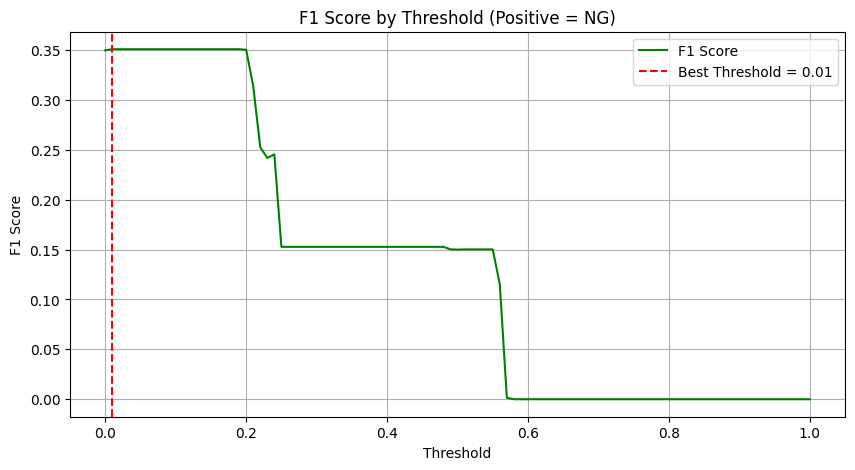

In [28]:
# ============================================================
# 📊 F1 Score 기반 Threshold 최적값 탐색 + 시각화
# ============================================================
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ 실제값 (양성=NG) 준비
y_true_ng = df_new['TAG'].map({'NG': 1, 'OK': 0}).iloc[WINDOW_SIZE-1:].to_numpy()
y_proba = proba_flipped  # NG 확률 사용

# 2️⃣ 여러 Threshold별 F1-score 계산
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_true_ng, (y_proba >= t).astype(int)) for t in thresholds]

# 3️⃣ 최적 Threshold 도출
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n✅ Best Threshold (NG 기준) = {best_threshold:.2f} (F1 = {best_f1:.3f})")

# 4️⃣ 시각화: F1 Score vs Threshold
plt.figure(figsize=(10,5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score by Threshold (Positive = NG)')
plt.legend()
plt.grid(True)
plt.show()


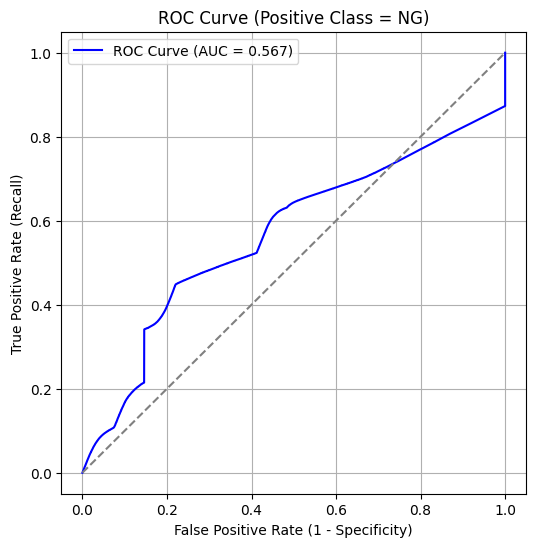

🎯 ROC AUC = 0.567


In [30]:
# ============================================================
# 📈 ROC Curve (Positive = NG)
# ============================================================
fpr, tpr, _ = roc_curve(1 - y_true_ng, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (Positive Class = NG)')
plt.legend()
plt.grid(True)
plt.show()

print(f"🎯 ROC AUC = {roc_auc:.3f}")

# 모델 성능 평가 (확률 반전 후: Positive = NG)

## 1. F1 Score 기반 Threshold 분석

-   **최적 Threshold:** 0.01
-   **F1 Score (at 0.01):** 0.351

### 해석

-   F1 Score가 가장 높은 지점이 0.01로, 모델이 **NG(불량)** 확률이 0.01 이상일 때 불량으로 예측하면 가장 균형 잡힌 성능을 보임
-   F1 Score 자체가 0.35 수준으로 낮기 때문에, **Precision과 Recall 모두 개선 여지**가 큼
-   즉, 모델이 NG를 탐지할 때 **정확하게 맞히는 비율(Precision)** 과 **놓치지 않고 탐지하는 비율(Recall)** 이 모두 충분히 높지 않음


## 2. ROC Curve (Positive Class = NG)

-   **AUC (Area Under Curve):** 0.567

### 해석

-   AUC=0.567은 완전 무작위(0.5)보다 **약간 더 나은 수준**
-   즉, 모델이 NG(불량)과 OK(정상)를 구분하는 능력이 **통계적으로 거의 랜덤 수준에 가까움**
-   ROC 곡선이 대각선(무작위 분류선)에 근접해 있어, 모델이 불량과 정상 간의 경계를 잘 구분하지 못함


## 3. 종합 분석
| 지표 | 값 | 해석 |
|------|------|--------------------------------|
| 최적 Threshold | 0.01 | 모델이 NG로 판단하는 기준 확률 |
| F1 Score | 0.351 | Precision/Recall 균형 낮음 |
| AUC | 0.567 | 분류 구분력 낮음 |
| Positive 기준 | NG(불량) | 반전 후 평가 기준 |


- 현재 모델은 **NG 판별력(불량 탐지력)** 이 부족
- 특히 Threshold가 매우 낮은 0.01에서만 성능이 유지된다는 점은, 모델이 **대부분의 데이터를 OK로 예측하고 있음**을 시사


## 4. 향후 개선 방향

1.  **데이터 재균형**
    -   NG(불량) 샘플이 매우 적은 경우, 모델이 정상(OK)에 과도하게 치우침 
    -   불균형 데이터를 **오버샘플링(SMOTE)** 또는 **언더샘플링**으로 보정 필요
2.  **특징(Feature) 중요도 점검**
    -   모델 입력 특성 중 NG/OK 구분에 기여도가 낮은 변수를 제거하고, 온도, 속도 등 주요 공정 변수를 강화
3.  **모델 구조 재검토**
    -   단순 LSTM보다 **Bidirectional LSTM**, **Attention Layer**, 또는 **CNN-LSTM 하이브리드 구조**로 개선
    -   불량 구간의 특징을 더 명확히 포착하는 방향 고려
4.  **Threshold 최적화 자동화**
    -   단일 F1 기준 외에도 **Precision-Recall Curve**를 활용하여 운영 환경(불량 탐지 민감도)에 맞는 Threshold 선택 자동화


## 결론
-   반전된 ROC AUC(0.567)는 이전 AUC(0.433)와 보완 관계로, **모델이 NG 탐지에 약간 더 나은 성능**을 보임
-   그러나 F1 Score가 낮고, Threshold가 극단적으로 낮은 구간에서만 성능이 나오는 것은 **모델 신뢰도가 낮음을 의미**함
-   데이터 재구성과 모델 개선을 통해 **불량 탐지 정확도 향상**이 필요함
